## 这是在实现paper中的算法中，用到的一些基本测试和实现笔记
* 帮助快速复现算法

------
目前包含的部分：
1. Spatial Transformer Networks
2. Crop and resize和进一步基于batch size的操作
3. STNM 用于实现 LR-GAN（to do）

### This is an simple implement of STN
    第一个实验是在pytorch框架下， 用affinegrid 和 gridsample实现空间变换网络操作的测试。
    [STN]<https://arxiv.org/abs/1506.02025>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.utils.data

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

空间变换网络涉及的主要数学操作为： 仿射变换； 在卷积神经网络中， 通常自身没有旋转不变性。

In [4]:
help(nn.functional.grid_sample)

Help on function grid_sample in module torch.nn.functional:

grid_sample(input, grid, mode='bilinear')
    Given an :attr:`input` and a flow-field :attr:`grid`, computes the
    `output` using input pixel locations from the grid.
    
    Uses bilinear interpolation to sample the input pixels.
    Currently, only spatial (4 dimensional) inputs are supported.
    
    For each output location, :attr:`grid` has `x` and `y`
    input pixel locations which are used to compute output.
    
    :attr:`grid` has values in the range of `[-1, 1]`. This is because the
    pixel locations are normalized by the input height and width.
    
    For example, values: x: -1, y: -1 is the left-top pixel of the input
                 values: x: 1, y: 1 is the right-bottom pixel of the input
    
    If :attr:`grid` has values outside the range of `[-1, 1]`, those locations
    are ignored (i.e. 0 is used as a contribution to the bilinear interpolation)
    
    .. Note:: This function is used in buildin

In [27]:
theta = Variable(torch.from_numpy(np.array([[[-1, 0.5, 1], [-1, 1, 0.5]]], dtype=np.float32)), requires_grad = True)
print(theta.size())
s = torch.FloatTensor(1, 3, 256, 256)
print(img.size())
grid = F.affine_grid(theta, img.size())
grid.size()

torch.Size([1, 2, 3])
torch.Size([1, 3, 128, 128])


torch.Size([1, 128, 128, 2])

torch.Size([1, 3, 128, 128])


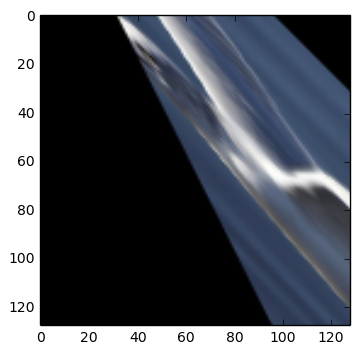

In [16]:
# 随机的变换参数得到的结果
stn = F.grid_sample(img, grid)
print(stn.size())
output = stn.data.numpy()
output = np.squeeze(output)
output = output.transpose([1,2,0])
plt.imshow(output)

In [2]:
# load the data 
# using cifar10 data for DCGAN
"""
dataset = datasets.ImageFolder(root='data/kaggle_small',
                           transform=transforms.Compose([
                               transforms.Scale(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
                                      )
"""
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, download=True,
                    transform=transforms.Compose([
                               transforms.Scale(32),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])),
    batch_size=50, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, download=False,
                    transform=transforms.Compose([
                               transforms.Scale(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])),
    batch_size=100, shuffle=False)
len(train_loader)
len(test_loader)

Files already downloaded and verified


100

* 数据加载
1. ToTensor是指把PIL.Image(RGB) 或者numpy.ndarray(H x W x C) 从0到255的值映射到0到1的范围内，并转化成Tensor格式。
2. Tensor的各种操作和Numpy的数组可以说是一样的， 并且可以互相转换， 不同的是Tensor可以放到GPU中进行加速运算

#### 在LeNet 的基础上， 加入STN网络结构， 对输入数据进行变换， 然后进行分类

* 首先需要定义： weight filler

In [3]:
def weight_filler(m):
    classname = m.__class__.__name__  #获取m的类型名
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
        self.STN = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        self.theta = nn.Sequential(
            nn.Linear(16*5*5, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
            
        )
        
    def forward(self, x):
             
        stn_o = self.STN(x)
        stn_o = stn_o.view(stn_o.size(0), -1)
        theta = self.theta(stn_o)
        theta = theta.view(-1, 2, 3)
        trans_out = F.affine_grid(theta, x.size())
        output = F.grid_sample(x, trans_out)
        
        out = F.relu(self.conv1(output))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        
        return out, output

In [5]:
cifar_net = LeNet()
cifar_net

LeNet (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
  (STN): Sequential (
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (theta): Sequential (
    (0): Linear (400 -> 64)
    (1): ReLU ()
    (2): Linear (64 -> 6)
  )
)

In [ ]:
# 将网络的参数适配不同的学习率， 对STN参数学习的部分使用0.0001倍的学习率
ignored_params = list(map(id, cifar_net.STN.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     cifar_net.parameters())
ignored_params

In [7]:
#setting training opt
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': base_params}, 
                       {'params': cifar_net.STN.parameters(), 'lr': 0.00001}], lr=0.01, momentum=0.9, weight_decay=5e-4)
#optimizer = optim.SGD(cifar_net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [8]:
def train(epoch):
    cifar_net.train()
    
    train_loss = 0
    correct = 0
    total = 0
    for i, (input, target) in enumerate(train_loader):
        optimizer.zero_grad()
        input, target = Variable(input), Variable(target)
        output, stn_out = cifar_net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
        _, predict = torch.max(output.data, 1)
        total += target.size(0)
        correct += predict.eq(target.data).cpu().sum()
        if(i%50==0):
            print('Loss: %.3f | train_Acc: %.3f%% (%d/%d)'
                    % (train_loss/(i+1), 100.*correct/total, correct, total))
            vutils.save_image(stn_out.data,
                            '%s/STN_%03d.png' % ('checkpoint', epoch))

In [9]:
def test(epoch):
    #global best_acc=0
    cifar_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs, stn_out = cifar_net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        if(batch_idx%10==0):
            print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
   
    print('Saving.. | test_accuracy: %.3f%%' %(acc))
    state = {
        'net': cifar_net,
        'test_acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7')
    torch.save(cifar_net.state_dict(), './checkpoint/model.pth')
    best_acc = acc 

In [ ]:
#对网络进行测试， 表明随着迭代的进行， 可以得到较好的训练结果
or epoch in range(50):
    train(epoch)
    test(epoch)

# 使用GAN 找到样本的attention patch
    *需要的一个操作： crop and resize

### 使用part 到 object的思路， 找到最具判别性的part； 这里需要用到 crop and resize的操作， 发掘具有表达力的信息

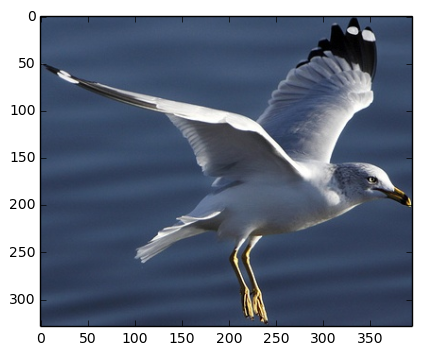

In [78]:
imgdir = '/home/magic/pyTroch/playground/Ring_Billed_Gull.jpg'
imgfakedir   = '/home/magic/Desktop/fake_samples_epoch_189.png'
imgfakebc1dir   = '/home/magic/Desktop/fakeBc1_epoch_189.png'
imgfakebc2dir  = '/home/magic/Desktop/fakeBc2_epoch_189.png'

img = Image.open(imgdir)
imgfake = Image.open(imgfakedir)
imgfakebc1 = Image.open(imgfakebc1dir)
imgfakebc2= Image.open(imgfakebc2dir)
#img = np.array(img)/255.0
plt.imshow(img)

In [111]:
# 这里参考pytorch vison transform里的crop的操作； 
class Crop_resize(object):
    """Crop the given PIL.Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        self.padding = padding

    def __call__(self, img, x, y, w):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        if w > img.size[0] / 2:
            w = img.size[0] / 2
            
        x1 = x
        y1 = y
        return img.crop((x1, y1, x1 + w, y1 + w))

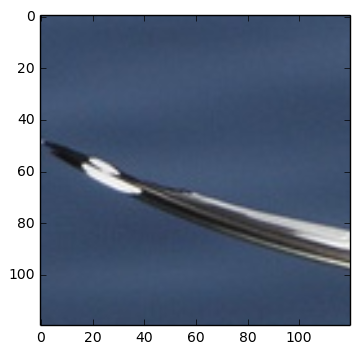

In [115]:
crop = Crop_resize(128)
imgcrop = crop(img, 2, 3, 120)
plt.imshow(imgcrop)

In [222]:
dataset = datasets.ImageFolder(root='/home/magic/pyTroch/gull',
                           transform=transforms.Compose([
                               transforms.Scale(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
                                      )

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=int(2))

In [249]:
class Crop_resize(object):
    """Crop the given PIL.Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        self.padding = padding
        self.toPIL = transforms.ToPILImage()
        self.toTensor = transforms.ToTensor()
    def __call__(self, img, x, y, w):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
	w = w * img.size(1)
	x = x * img.size(1)
        y = y * img.size(2)

        if w > img.size(1) / 4:
            w = img.size(1) / 4

        if (x > 224):
    	    x = 224
        if (x < 32):
	    x = 32
        if (y > 224):
    	    y = 224
        if (y < 32):
	    y = 32
        x1 = int(x)
	y1 = int(y)
        w1 = int(w)
	img = (img + 1) / 2. #convert norm img(-1, 1) to (0, 1)	
	
        img = self.toPIL(img.resize_(img.size(0), img.size(1), img.size(3)))
        #print('x1: {} y1: {} x2: {} y2: {}'.format(x1 - w1/2, y1 - w1/2, x1 + w1/2, y1 + w1/2))
        img.save('gullcrop.png')
        crop_img = self.toTensor(img.crop((x1 - w1/2, y1 - w1/2, x1 + w1/2, y1 + w1/2)).resize((256,256)))
        return crop_img.resize_(1,3,256,256)

In [275]:
paras = torch.rand(32, 3)
print(paras[0])
w = paras[:,2]


 0.6087
 0.3806
 0.6688
[torch.FloatTensor of size 3]



In [253]:
# 实现基于batch size 的操作
print(x1[0])
crop = Crop_resize(256)
for i, data in enumerate(dataloader):
    input, _ = data
    inputs = torch.zeros(input.size(0), input.size(1), input.size(2), input.size(3))
    for i in range(input.size(0)):       
        inputs[i] = crop(input[i], x1, y1, w1) 
    vutils.save_image(inputs,
                             'crop_samples.png' )


 0.4415
[torch.FloatTensor of size 1]



In [215]:
img_batch = np.expand_dims(img, 0)
inputImages = torch.from_numpy(img_batch.astype(np.float32))
inputImages = inputImages.view(1, inputImages.size(3), inputImages.size(1), inputImages.size(2))
inputImages.size()

torch.Size([1, 3, 329, 395])

In [148]:
# 加载测试图像
import torchvision.utils as vutils

loader = transforms.Compose([
    transforms.Scale(256),  # scale imported image
    transforms.CenterCrop(256),
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image), requires_grad = True)
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image
img = image_loader(imgdir)
img.size()
print(img.size())
x = 98
y = 76
w = 64

torch.Size([1, 3, 256, 256])


### 实现一步一步的图像合成
* 图像的结构信息
* 图像的细节信息
* 图像的颜色信息

In [23]:
# 测试LSTM在参数传递过程中的操作
nz = 10
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc = nn.Linear(nz , nz)
        self.rnn = nn.LSTMCell(10, 10)
        self.relu = nn.ReLU()
        
    def forward(self, input):
        hx = Variable(torch.randn(1, 10))
        cx = Variable(torch.randn(1, 10))
        
        out = self.relu(self.fc(input))
        inputs = out.view(2, 1, 10)
        output = []
        for i in range(2):
            hx, cx = self.rnn(inputs[i], (hx, cx))
            output.append(hx)
        return out

fcnet = net()


input = Variable(torch.randn(2, 10))
output = fcnet(input)

output

Variable containing:
 0.0251  0.0000  0.4721  0.4062  0.0000  0.1222  0.0000  0.3939  0.0000  0.0000
 0.0000  0.0000  0.3520  0.0000  0.0291  0.2154  0.0000  0.2928  1.1053  0.0000
[torch.FloatTensor of size 2x10]

### 将图像表示为 用前景 背景 和 mask之间的运算得到的

In [89]:
class STNM(nn.Module):
    def __init__(self):
        super(STNM, self).__init__()  
    
    def forward(self, canvas, fgimg, fggrid, fgmask):
        #print('grid size: {} img_size: {}'.format(fggrid.size(), fgimg.size()))
        mask = F.grid_sample(fgmask, fggrid)
        fg = F.grid_sample(fgimg, fggrid)
        #torch.addcmul(tensor, value=1, tensor1, tensor2, out=None) → Tensor
        tmp1 = torch.FloatTensor(fg.size(0), fg.size(1), fg.size(2), fg.size(3))
        torch.addcmul(tmp1, mask.data, fg.data) 
        
        ng_mask = -1*mask 
        out = torch.add(ng_mask, 1)
        #print(out)
        tmp2 = torch.FloatTensor(out.size(0), out.size(1), out.size(2), out.size(3))
        torch.addcmul(tmp2, out.data, canvas.data)
        
        return Variable(tmp1+tmp2, requires_grad = True), Variable(tmp1)

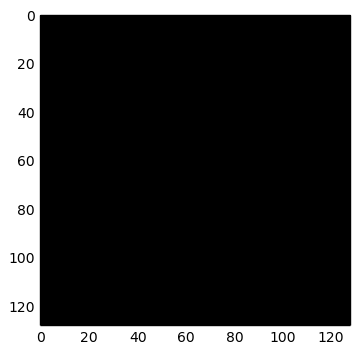

In [90]:
stnm = STNM()
m, t = stnm(img, img, grid, img)
t.size()
output = t.data.numpy()
output = np.squeeze(output)
output = output.transpose([1,2,0])
plt.imshow(output)